
# Sistema de Recomendación de Películas y Series de Netflix

Este notebook implementa un sistema de recomendación **basado en contenido** utilizando el dataset **netflix_titles.csv**.  
Se emplea procesamiento de lenguaje natural para analizar las descripciones y recomendar títulos similares.



## Introducción

Se trata de un recomendador sencillo basado en contenido. Usaremos la descripción de películas y series para calcular similitudes y sugerir títulos parecidos.



## Importar librerías

Importamos las librerías necesarias para el procesamiento de datos, visualización y cálculo de similitud.


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel



## Cargar el dataset

Leemos el archivo CSV que contiene el catálogo de Netflix.


In [2]:

netflix_dataset = pd.read_csv('netflix_all_detailed_up_to_2025.csv')
netflix_dataset.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,genres,language,description,popularity,vote_count,vote_average,budget,revenue
0,33238,TV Show,Running Man,안재철,"Yoo Jae-suk, Jee Seok-jin, Kim Jong-kook, Haha...",South Korea,2010-07-11,2010,8.241,1 Seasons,"Comedy, Reality",ko,A reality and competition show where members a...,1929.898,187,8.241,NaN,NaN
1,32415,TV Show,Conan,NaN,"Conan O'Brien, Andy Richter",United States of America,2010-11-08,2010,7.035,1 Seasons,"Talk, Comedy, News",en,A late night television talk show hosted by C...,1670.580,229,7.035,NaN,NaN
2,37757,TV Show,MasterChef Greece,NaN,NaN,Greece,2010-10-03,2010,5.600,1 Seasons,Reality,el,MasterChef Greece is a Greek competitive cooki...,1317.092,6,5.600,NaN,NaN
3,75685,TV Show,Prostřeno!,NaN,"Václav Vydra, Jana Boušková",Czech Republic,2010-03-01,2010,6.500,1 Seasons,Reality,cs,The knives (and forks) are out as a group of s...,1095.776,6,6.500,NaN,NaN
4,33847,TV Show,The Talk,NaN,"Amanda Kloots, Jerry O'Connell, Akbar Gbaja-Bi...","United States of America, Ireland",2010-10-18,2010,3.400,1 Seasons,Talk,en,A panel of well-known news and entertainment p...,712.070,12,3.400,NaN,NaN



## Vista preliminar de los datos

Mostramos las primeras filas para revisar la estructura.


In [3]:

netflix_dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   show_id       32000 non-null  int64  
 1   type          32000 non-null  object 
 2   title         32000 non-null  object 
 3   director      20903 non-null  object 
 4   cast          30639 non-null  object 
 5   country       29737 non-null  object 
 6   date_added    32000 non-null  object 
 7   release_year  32000 non-null  int64  
 8   rating        32000 non-null  float64
 9   duration      16000 non-null  object 
 10  genres        30919 non-null  object 
 11  language      32000 non-null  object 
 12  description   28662 non-null  object 
 13  popularity    32000 non-null  float64
 14  vote_count    32000 non-null  int64  
 15  vote_average  32000 non-null  float64
 16  budget        16000 non-null  float64
 17  revenue       16000 non-null  float64
dtypes: float64(5), int64(3), o


## Información del dataset

Identificamos los valores unicos


In [4]:
unique_counts = {}

for i in list(netflix_dataset.columns):
    unique_counts[i] = netflix_dataset[i].value_counts().shape[0]

print(pd.DataFrame(unique_counts, index=["unique count"]).transpose())


              unique count
show_id              31594
type                     2
title                30639
director             13011
cast                 30230
country               1745
date_added            5504
release_year            16
rating                2728
duration                 1
genres                3895
language                83
description          28636
popularity           24159
vote_count            2902
vote_average          2728
budget                 958
revenue               5327



## Verificación de valores nulos

Identificamos cuántos valores faltantes hay en cada columna.


In [5]:

print('Table of missing values: ')
print(netflix_dataset.isnull().sum())


Table of missing values: 
show_id             0
type                0
title               0
director        11097
cast             1361
country          2263
date_added          0
release_year        0
rating              0
duration        16000
genres           1081
language            0
description      3338
popularity          0
vote_count          0
vote_average        0
budget          16000
revenue         16000
dtype: int64


## Análisis de películas vs programas de televisión

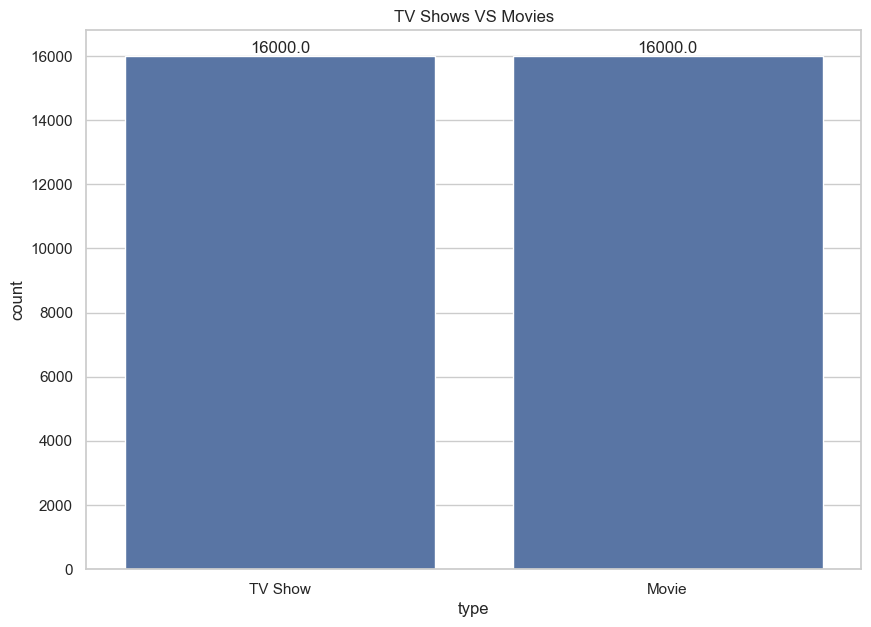

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.set(style='whitegrid')
ax = sns.countplot(x="type", data=netflix_dataset)
ax.set_title("TV Shows VS Movies")

# Agregar los totales encima de las barras
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2, height), 
                ha='center', va='bottom', fontsize=12)

plt.show()

In [26]:
# Contar títulos únicos por type
unique_counts = netflix_dataset.groupby('type')['title'].nunique()

print(unique_counts)


type
Movie      15485
TV Show    15668
Name: title, dtype: int64


## ¿En qué mes un productor puede publicar su contenido? (Mes con menor cantidad de contenido añadido)

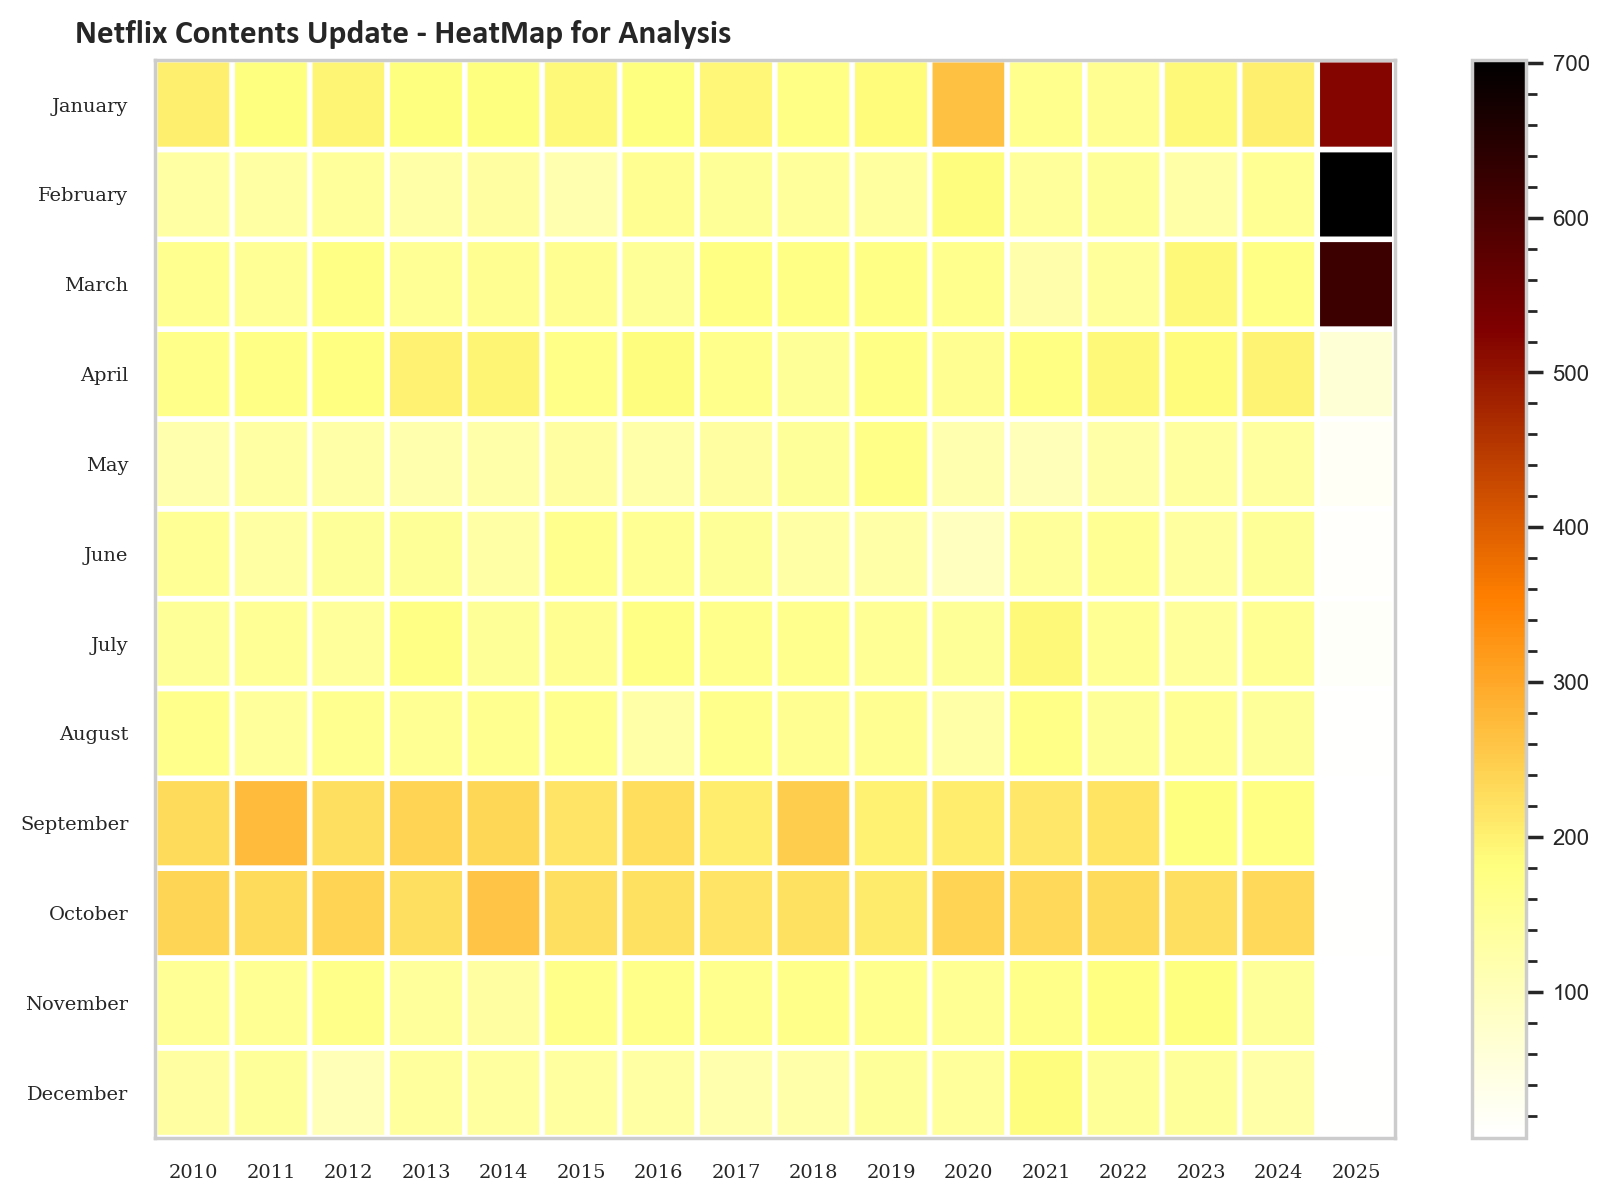

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Convertir a datetime, ignorar errores
netflix_date = netflix_dataset[['date_added']].dropna()
netflix_date['date_added'] = pd.to_datetime(netflix_date['date_added'], errors='coerce')

# Filtrar fechas válidas
netflix_date = netflix_date.dropna()

# Extraer año y nombre del mes
netflix_date['year'] = netflix_date['date_added'].dt.year
netflix_date['month'] = netflix_date['date_added'].dt.month_name()

# Orden de meses (de diciembre a enero)
month_order = ['December', 'November', 'October', 'September', 'August', 'July',
               'June', 'May', 'April', 'March', 'February', 'January']

# Agrupar
df = netflix_date.groupby('year')['month'].value_counts().unstack().fillna(0)[month_order].T

# Graficar heatmap
plt.figure(figsize=(10, 7), dpi=200)
plt.pcolor(df, cmap='afmhot_r', edgecolors='white', linewidths=2)

plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, fontsize=7, fontfamily='serif')
plt.yticks(np.arange(0.5, len(df.index), 1), df.index, fontsize=7, fontfamily='serif')

plt.title('Netflix Contents Update - HeatMap for Analysis',
          fontsize=12, fontfamily='calibri', fontweight='bold', position=(0.20, 1.02))

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=8)
cbar.ax.minorticks_on()

plt.show()


## Análisis de calificaciones de películas

C:\Users\52746\AppData\Local\Temp\ipykernel_3764\2722599957.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




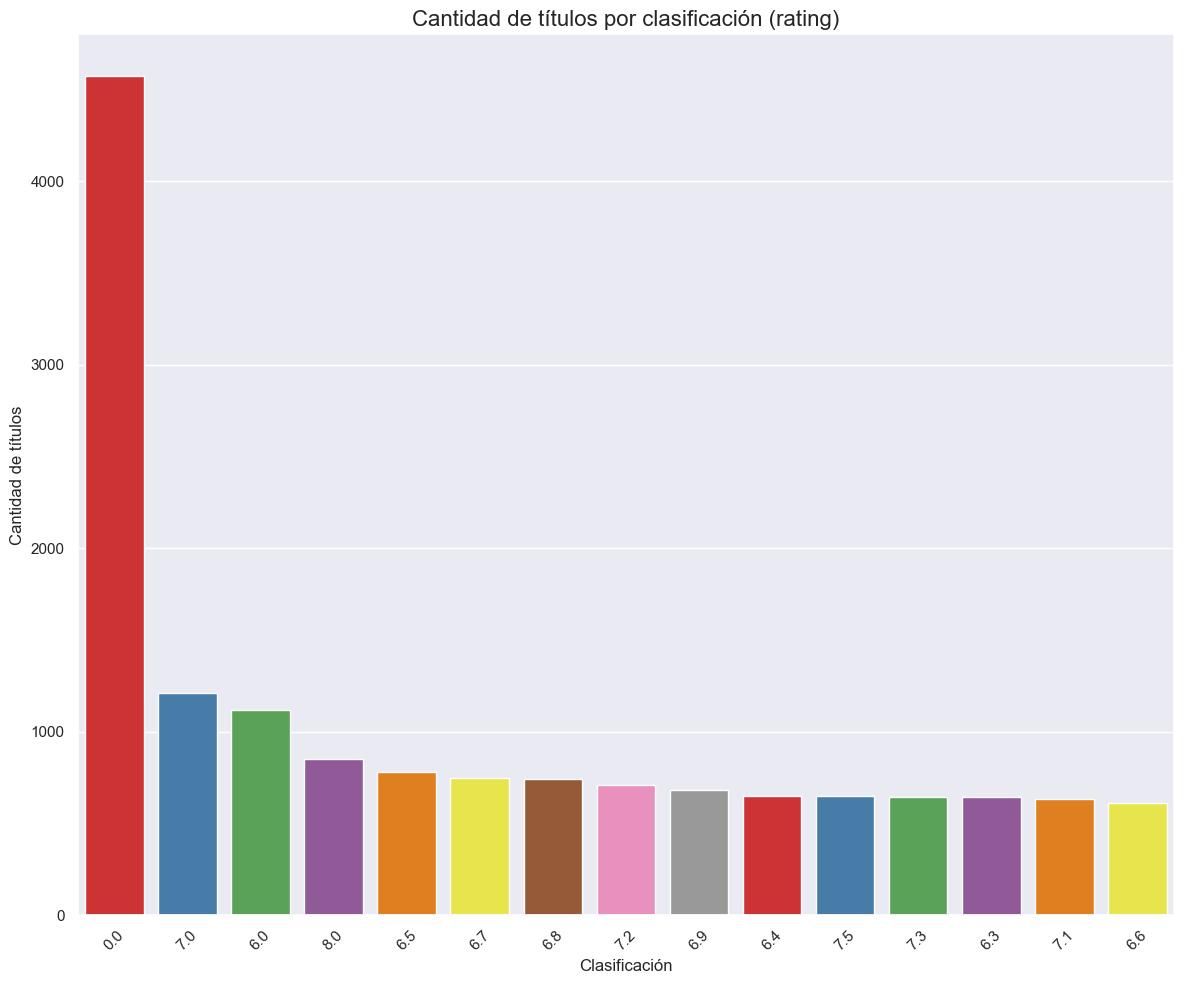

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar a DataFrame
ratings = netflix_dataset[['rating']].dropna()

plt.figure(figsize=(12, 10))
sns.set(style="darkgrid")

ax = sns.countplot(
    x='rating',
    data=ratings,
    palette='Set1',
    order=ratings['rating'].value_counts().index[:15]
)

plt.title('Cantidad de títulos por clasificación (rating)', fontsize=16)
plt.xlabel('Clasificación', fontsize=12)
plt.ylabel('Cantidad de títulos', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Análisis de las calificaciones de IMDB para obtener las películas mejor valoradas en Netflix

In [30]:
# Seleccionar columnas relevantes
ratings = netflix_dataset[['title', 'release_year', 'vote_average', 'genres']].copy()

# Renombrar columnas para que coincidan con el código anterior
ratings.columns = ['Title', 'Release Year', 'Rating', 'Genre']

# Eliminar duplicados
ratings.drop_duplicates(subset=['Title', 'Release Year', 'Rating'], inplace=True)

# Mostrar tamaño final
ratings.shape


(31985, 4)

## Realizar una unión interna en el conjunto de datos de calificaciones y el conjunto de datos de Netflix para obtener el contenido que tiene ambas calificaciones en IMDB y está disponible en Netflix.

In [18]:
## ratings.dropna()
## joint_data=ratings.merge(netflix_dataset,left_on='Title',right_on='title',how='inner')
## joint_data=joint_data.sort_values(by='Rating', ascending=False) 

## Top rated 10 movies in Netflix

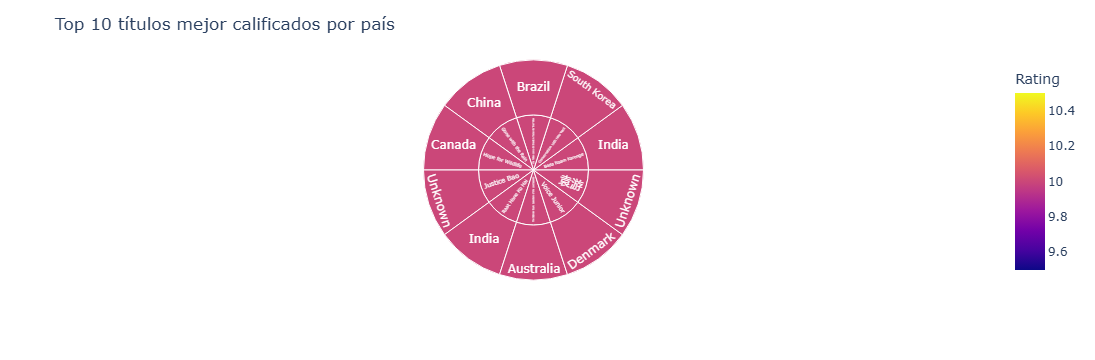

In [31]:
import plotly.express as px

# Filtrar los 10 títulos con mejor rating (sin nulos)
top_rated = netflix_dataset[['title', 'country', 'vote_average']].dropna().sort_values(by='vote_average', ascending=False).head(10)

# Renombrar columna para que coincida con el original
top_rated = top_rated.rename(columns={'vote_average': 'Rating'})

# Gráfico Sunburst
fig = px.sunburst(
    top_rated,
    path=['title', 'country'],
    values='Rating',
    color='Rating'
)

fig.update_layout(title='Top 10 títulos mejor calificados por país')
fig.show()


## **Top countries creating contents**

In [32]:
# Contar cuántos títulos tiene cada país
country_count = netflix_dataset['country'].value_counts().sort_values(ascending=False)

# Convertir a DataFrame
country_count = pd.DataFrame(country_count)

# Obtener los 11 principales
topcountries = country_count.head(11)

topcountries


,count
country,
United States of America,7760
Japan,2587
Unknown,2263
China,2004
South Korea,1999
United Kingdom,1106
France,855
India,771
Canada,738


## **Year wise analysis**

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar últimos 15 años automáticamente
current_year = netflix_dataset['release_year'].max()
Last_fifteen_years = netflix_dataset[netflix_dataset['release_year'] >= current_year - 14]

# Mostrar primeras filas (opcional)
Last_fifteen_years.head()


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,genres,language,description,popularity,vote_count,vote_average,budget,revenue
1000,52910,TV Show,Law of the Jungle,Lee Ji-won,Kim Byung-man,South Korea,2011-10-21,2011,4.7,1 Seasons,Reality,ko,Law of the Jungle is a hybrid reality show com...,980.270,7,4.7,NaN,NaN
1001,1399,TV Show,Game of Thrones,NaN,"Peter Dinklage, Kit Harington, Nikolaj Coster-...","United Kingdom, United States of America",2011-04-17,2011,8.5,1 Seasons,"Sci-Fi & Fantasy, Drama, Action & Adventure",en,Seven noble families fight for control of the ...,812.157,24664,8.5,NaN,NaN
1002,52823,TV Show,Weekly Idol,NaN,NaN,South Korea,2011-07-23,2011,6.2,1 Seasons,Talk,ko,Weekly Idol is back with all new hosts. Cho Sa...,822.081,8,6.2,NaN,NaN
1003,122801,TV Show,Skilz,NaN,"Bab Buelens, Stijn Steyaert, Lander Depoortere...",Belgium,2011-09-27,2011,2.0,1 Seasons,NaN,nl,NaN,657.163,1,2.0,NaN,NaN
1004,39084,TV Show,The Chew,NaN,"Carla Hall, Clinton Kelly, Michael Symon",NaN,2011-09-26,2011,5.5,1 Seasons,Talk,en,The Chew is an American talk show/cooking show...,608.030,6,5.5,NaN,NaN


C:\Users\52746\AppData\Local\Temp\ipykernel_3764\4267240369.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




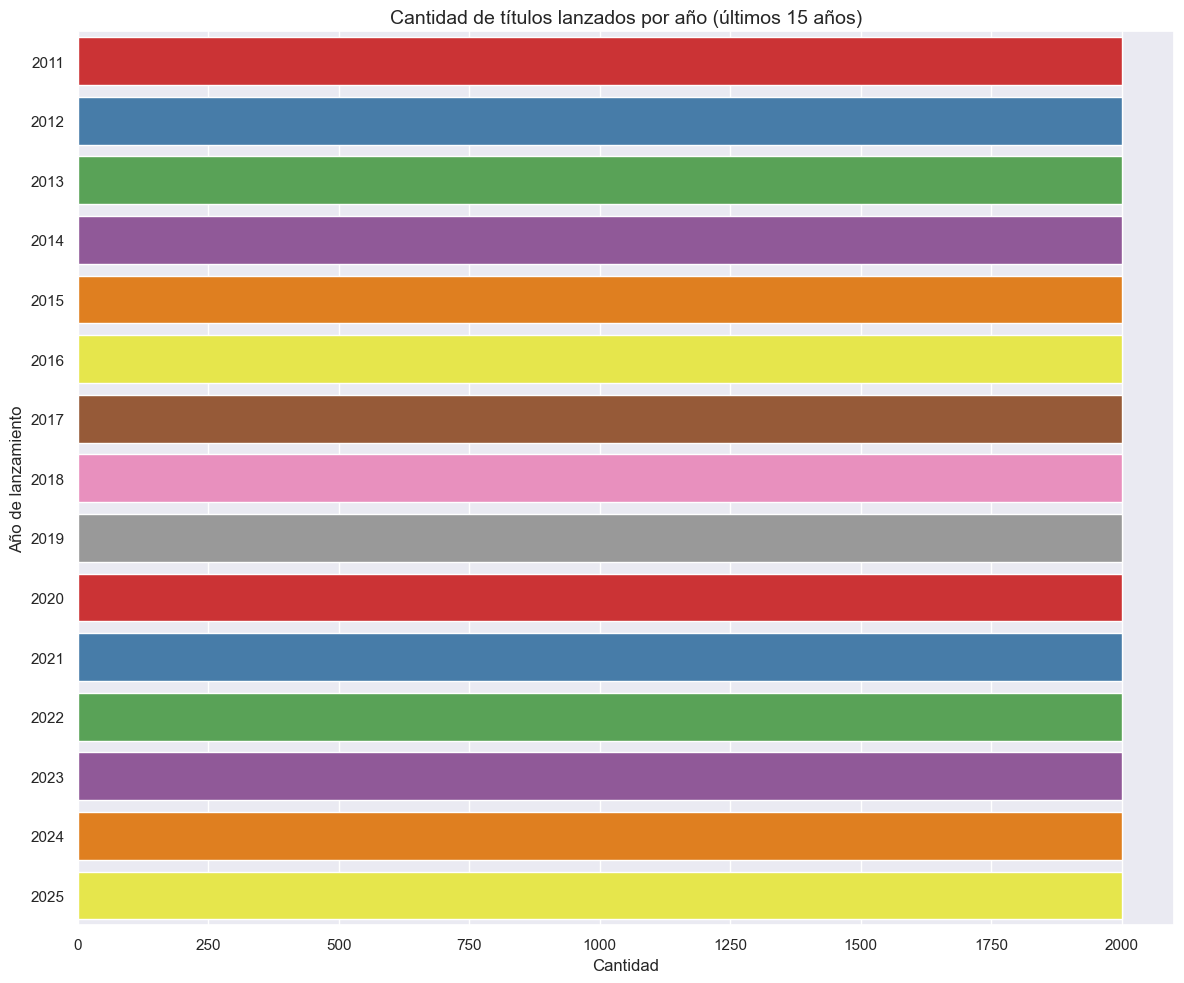

In [34]:
# Filtrar datos para últimos 15 años
current_year = netflix_dataset['release_year'].max()
last_fifteen_years = netflix_dataset[netflix_dataset['release_year'] >= (current_year - 14)]

# Graficar
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.set(style="darkgrid")

ax = sns.countplot(
    y='release_year',
    data=last_fifteen_years,
    palette='Set1',
    order=last_fifteen_years['release_year'].value_counts().index[:15]
)

plt.title('Cantidad de títulos lanzados por año (últimos 15 años)', fontsize=14)
plt.xlabel('Cantidad')
plt.ylabel('Año de lanzamiento')
plt.tight_layout()
plt.show()


## **Analysis of TV Shows in Netflix** 

In [41]:
#Analysis of TV Shows in Netflix

countries={}
netflix_shows['country']=netflix_shows['country'].fillna('Unknown')
cou=list(netflix_shows['country'])
for i in cou:
    #print(i)
    i=list(i.split(','))
    if len(i)==1:
        if i in list(countries.keys()):
            countries[i]+=1
        else:
            countries[i[0]]=1
    else:
        for j in i:
            if j in list(countries.keys()):
                countries[j]+=1
            else:
                countries[j]=1

In [42]:
countries_fin={}
for country,no in countries.items():
    country=country.replace(' ','')
    if country in list(countries_fin.keys()):
        countries_fin[country]+=no
    else:
        countries_fin[country]=no
        
countries_fin={k: v for k, v in sorted(countries_fin.items(), key=lambda item: item[1], reverse= True)}

C:\Users\52746\AppData\Local\Temp\ipykernel_3764\3241309445.py:5: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



[Text(0, 0, 'UnitedStatesofAmerica'),
 Text(1, 0, 'UnitedKingdom'),
 Text(2, 0, 'France'),
 Text(3, 0, 'Canada'),
 Text(4, 0, 'Germany'),
 Text(5, 0, 'Mexico'),
 Text(6, 0, 'SouthKorea'),
 Text(7, 0, 'Ireland'),
 Text(8, 0, 'Japan'),
 Text(9, 0, 'Italy')]

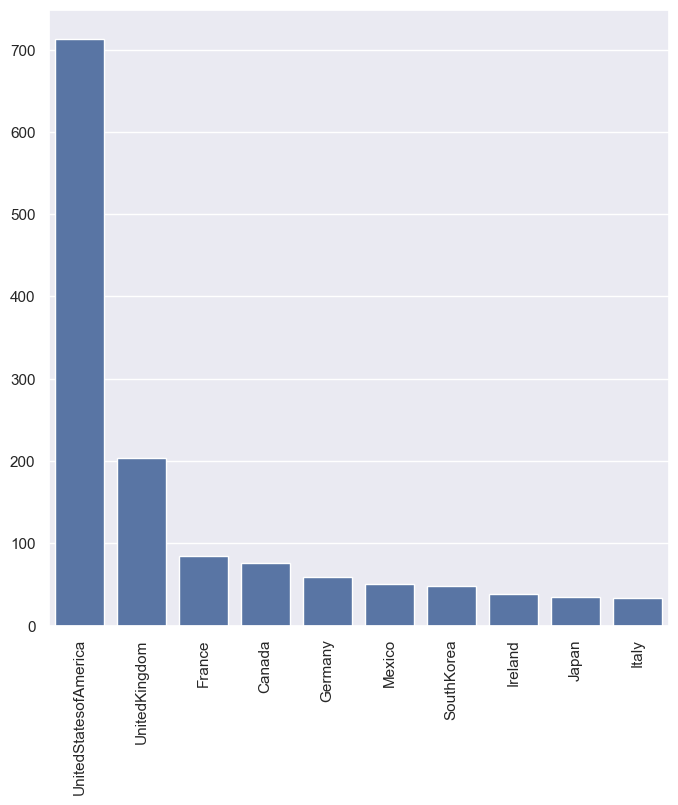

In [43]:
# Top 10 TV shows creating countries.

plt.figure(figsize=(8,8))
ax = sns.barplot(x=list(countries_fin.keys())[0:10],y=list(countries_fin.values())[0:10])
ax.set_xticklabels(list(countries_fin.keys())[0:10],rotation = 90)

## **Analysis of duration of movies** 

In [54]:
# 1️⃣ Filtrar solo películas
netflix_movies = netflix_dataset[netflix_dataset['type'] == 'Movie'].copy()

# 2️⃣ Quitar nulos en duración
netflix_movies = netflix_movies[netflix_movies['duration'].notna()]

# 3️⃣ Extraer solo los números (soporta "93 min", "93min", etc.)
netflix_movies['duration'] = netflix_movies['duration'].str.extract(r'(\d+)')

# 4️⃣ Quitar nuevamente nulos (si alguna fila no tenía números)
netflix_movies = netflix_movies[netflix_movies['duration'].notna()]

# 5️⃣ Convertir a entero
netflix_movies['duration'] = netflix_movies['duration'].astype(int)

# 6️⃣ Ver resultado limpio
netflix_movies[['title', 'duration']].head()


,title,duration


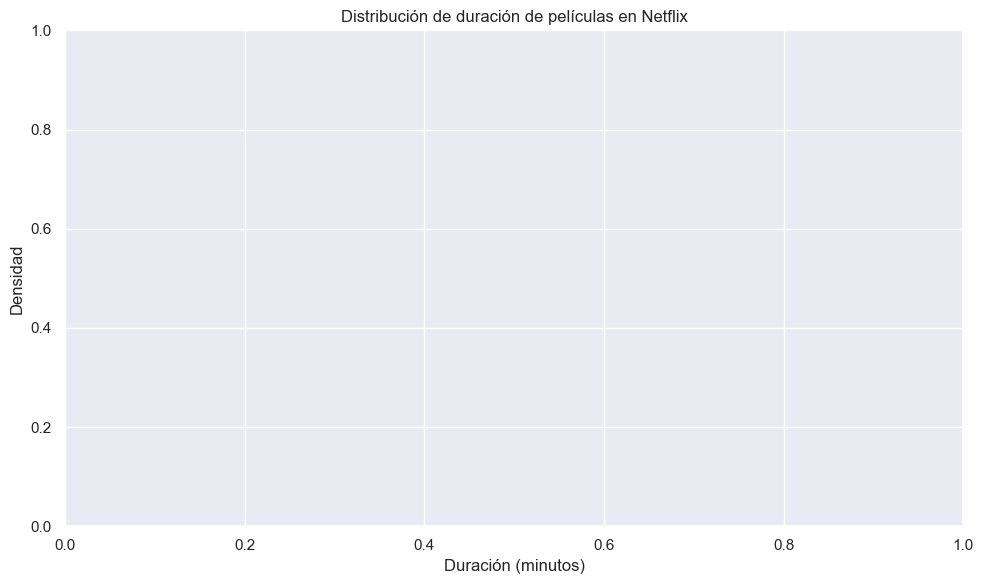

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))

ax = sns.kdeplot(data=netflix_movies['duration'], fill=True, color='green')

plt.title('Distribución de duración de películas en Netflix')
plt.xlabel('Duración (minutos)')
plt.ylabel('Densidad')
plt.tight_layout()
plt.show()


## **Analysis of duration of TV shows**

In [57]:
# Seleccionar solo columnas necesarias y hacer COPIA segura
features = ['title', 'duration']
durations = netflix_shows[features].copy()

# Limpiar la columna 'duration'
durations['no_of_seasons'] = durations['duration'].str.replace(' Season', '', regex=False)
durations['no_of_seasons'] = durations['no_of_seasons'].str.replace('s', '', regex=False)

# Convertir a entero
durations['no_of_seasons'] = durations['no_of_seasons'].astype(int)

# Ver resultado
durations.head()


,title,duration,no_of_seasons
0,Running Man,1 Seasons,1
1,Conan,1 Seasons,1
2,MasterChef Greece,1 Seasons,1
3,Prostřeno!,1 Seasons,1
4,The Talk,1 Seasons,1


In [61]:
durations['no_of_seasons']=durations['no_of_seasons'].astype(str).astype(int)

In [62]:
#TV shows with largest number of seasons
t=['title','no_of_seasons']
top=durations[t]

top=top.sort_values(by='no_of_seasons', ascending=False)

<Axes: xlabel='title'>

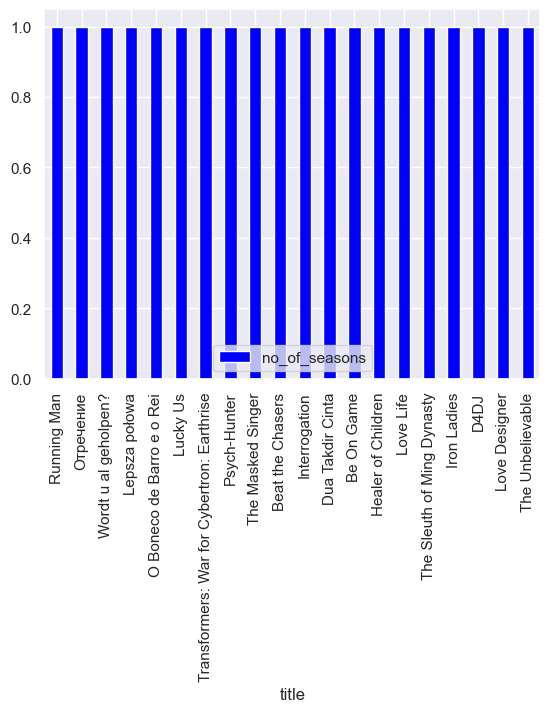

In [63]:
top20=top[0:20]
top20.plot(kind='bar',x='title',y='no_of_seasons', color='blue')

# **Content-Based Recommendation System** 

## **Plot description based Recommender (Content Based Recommendations)**

In [64]:
#Plot description based Recommender (Content Based Recommendations)

netflix_dataset['description'].head()

0    A reality and competition show where members a...
1    A late night television talk show hosted by  C...
2    MasterChef Greece is a Greek competitive cooki...
3    The knives (and forks) are out as a group of s...
4    A panel of well-known news and entertainment p...
Name: description, dtype: object

In [86]:
#Recommedation System(Content Based)

#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a', etc.
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
netflix_dataset['description'] = netflix_dataset['description'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(netflix_dataset['description'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(32000, 54565)

In [88]:
# -------------------------------
# Usar todos los datos con descripción válida
# -------------------------------
netflix_dataset['description'] = netflix_dataset['description'].fillna('')

all_data = netflix_dataset[netflix_dataset['description'].notna()].copy()

print(f"Filas seleccionadas: {all_data.shape[0]}")

# -------------------------------
# TF-IDF
# -------------------------------
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(all_data['description'])

print(f"Forma del TF-IDF matrix: {tfidf_matrix.shape}")

# -------------------------------
# Similaridades
# -------------------------------
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(f"Forma de la matriz de similitud: {cosine_sim.shape}")

# -------------------------------
# Mapear títulos a índices válidos
# -------------------------------
indices = pd.Series(all_data.index, index=all_data['title']).drop_duplicates()

print(f"Cantidad de títulos indexados: {len(indices)}")

# -------------------------------
# Función de recomendación segura
# -------------------------------
def get_recommendations(title, cosine_sim=cosine_sim):
    if title not in indices:
        raise ValueError(f"'{title}' no está en el dataset de títulos con descripción válida.")
    
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    
    return all_data['title'].iloc[movie_indices]



Filas seleccionadas: 32000
Forma del TF-IDF matrix: (32000, 54565)
Forma de la matriz de similitud: (32000, 32000)
Cantidad de títulos indexados: 32000


In [89]:
get_recommendations('Inception')

16583    Inception: The Cobol Job
19148                   New World
27662                  Homunculus
19321            The Monkey's Paw
23210                    Altitude
14232          Lumuhod Ka Sa Lupa
3692                     Shen Tou
5932                     Mindfuck
13566                 Rabbit Hole
2998                      La fuga
Name: title, dtype: object

In [90]:
get_recommendations('Avengers: Infinity War')

25001                                    Avengers: Endgame
23413    LEGO Marvel Super Heroes: Guardians of the Gal...
3114                                     Marvel's Avengers
30298             LEGO Marvel Avengers: Mission Demolition
24963                            Avengers Grimm: Time Wars
29378                       LEGO Marvel Avengers: Code Red
4652                        Marvel Disk Wars: The Avengers
9758                                               Pandora
19370                     Phineas and Ferb: Mission Marvel
135                 The Avengers: Earth's Mightiest Heroes
Name: title, dtype: object

In [91]:
get_recommendations('Dil Dhadakne Do')

19567                                 Le Week-End
22458                             The Family Fang
24746                  There's No Place Like Home
21762                            One Crazy Cruise
19868                               Family United
24672                        What Keeps You Alive
29961    My Brother-in-law Is Looking For Me Only
25283                   My Sister-in-law's Secret
8964                          Frankenstein Family
5070                                Iron Lady Cha
Name: title, dtype: object

### Content based filtering on multiple metrics

Content based filtering on the following factors:

* Title
* Cast
* Director
* Listed in
* Plot

In [100]:
#Filling null values with empty string.
filledna=netflix_dataset.fillna('')
filledna.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,genres,language,description,popularity,vote_count,vote_average,budget,revenue
0,33238,TV Show,Running Man,안재철,"Yoo Jae-suk, Jee Seok-jin, Kim Jong-kook, Haha...",South Korea,2010-07-11,2010,8.241,1 Seasons,"Comedy, Reality",ko,A reality and competition show where members a...,1929.898,187,8.241,,
1,32415,TV Show,Conan,,"Conan O'Brien, Andy Richter",United States of America,2010-11-08,2010,7.035,1 Seasons,"Talk, Comedy, News",en,A late night television talk show hosted by C...,1670.580,229,7.035,,
2,37757,TV Show,MasterChef Greece,,,Greece,2010-10-03,2010,5.600,1 Seasons,Reality,el,MasterChef Greece is a Greek competitive cooki...,1317.092,6,5.600,,
3,75685,TV Show,Prostřeno!,,"Václav Vydra, Jana Boušková",Czech Republic,2010-03-01,2010,6.500,1 Seasons,Reality,cs,The knives (and forks) are out as a group of s...,1095.776,6,6.500,,
4,33847,TV Show,The Talk,,"Amanda Kloots, Jerry O'Connell, Akbar Gbaja-Bi...","United States of America, Ireland",2010-10-18,2010,3.400,1 Seasons,Talk,en,A panel of well-known news and entertainment p...,712.070,12,3.400,,


In [99]:
#Cleaning the data - making all the words lower case
def clean_data(x):
        return str.lower(x.replace(" ", ""))

In [102]:
# 1. Reemplazar nulos con string vacío
filledna = netflix_dataset.fillna('')
# 2. Ver qué columnas tiene realmente
print("Columnas disponibles en filledna:")
print(filledna.columns.tolist())

# 3. Definir features pero solo quedarnos con las que existen
features = ['title', 'director', 'cast', 'listed_in', 'description']
existing_features = [col for col in features if col in filledna.columns]

print(f"\nUsando columnas existentes: {existing_features}")

# 4. Filtrar dataframe
filledna = filledna[existing_features]
# 5. Aplicar limpieza solo a columnas que existen



Columnas disponibles en filledna:
['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'genres', 'language', 'description', 'popularity', 'vote_count', 'vote_average', 'budget', 'revenue']

Usando columnas existentes: ['title', 'director', 'cast', 'description']


In [103]:
for feature in existing_features:
    filledna[feature] = filledna[feature].apply(clean_data)

# 6. Verificar resultado
filledna.head()



,title,director,cast,description
0,runningman,안재철,"yoojae-suk,jeeseok-jin,kimjong-kook,haha,songj...",arealityandcompetitionshowwheremembersarejoine...
1,conan,,"conano'brien,andyrichter",alatenighttelevisiontalkshowhostedbyconano'brien.
2,masterchefgreece,,,masterchefgreeceisagreekcompetitivecookinggame...
3,prostřeno!,,"václavvydra,janaboušková",theknives(andforks)areoutasagroupofstrangersco...
4,thetalk,,"amandakloots,jerryo'connell,akbargbaja-biamila...",apanelofwell-knownnewsandentertainmentpersonal...


In [120]:
def create_soup(x):
    return x['title'] + ' ' + x['director'] + ' ' + x['cast'] + x['description']

filledna['soup'] = filledna.apply(create_soup, axis=1)

In [129]:
from sklearn.metrics.pairwise import cosine_similarity

def get_recommendations_full(title, top_n=10):
    if title not in indices:
        # Sugerencia de corrección si no está
        suggestions = filledna[filledna['title'].str.contains(title.split()[0], case=False, na=False)]['title'].tolist()
        raise ValueError(f"'{title}' no está en el dataset.\nQuizá quisiste uno de estos:\n{suggestions}")
    
    idx = indices[title]
    sim_scores = cosine_similarity(count_matrix[idx], count_matrix).flatten()
    sim_indices = sim_scores.argsort()[::-1]
    sim_indices = sim_indices[sim_indices != idx]
    sim_indices = sim_indices[:top_n]
    
    return filledna['title'].iloc[sim_indices]


In [130]:
get_recommendations_new('Shrek Forever After')

21295                             Avengers Grimm
24963                  Avengers Grimm: Time Wars
17977                    Shrek: Once Upon a Time
30341                                     Thelma
20883    The Disappearance of Eleanor Rigby: Him
20661    The Disappearance of Eleanor Rigby: Her
19115                          Shrek the Musical
28596                The Railway Children Return
8671              Star Wars Galaxy of Adventures
16508                                     Sintel
Name: title, dtype: object

In [131]:
get_recommendations_new('Avengers: Infinity War')

25001                                    Avengers: Endgame
23413    LEGO Marvel Super Heroes: Guardians of the Gal...
3114                                     Marvel's Avengers
30298             LEGO Marvel Avengers: Mission Demolition
24963                            Avengers Grimm: Time Wars
29378                       LEGO Marvel Avengers: Code Red
4652                        Marvel Disk Wars: The Avengers
9758                                               Pandora
19370                     Phineas and Ferb: Mission Marvel
135                 The Avengers: Earth's Mightiest Heroes
Name: title, dtype: object

In [132]:
get_recommendations_new('Dil Dhadakne Do')

19567                                 Le Week-End
22458                             The Family Fang
24746                  There's No Place Like Home
21762                            One Crazy Cruise
19868                               Family United
24672                        What Keeps You Alive
29961    My Brother-in-law Is Looking For Me Only
25283                   My Sister-in-law's Secret
8964                          Frankenstein Family
5070                                Iron Lady Cha
Name: title, dtype: object


## Conclusión

Este notebook demuestra un sistema de recomendación **basado en contenido** que usa las descripciones de los títulos para encontrar similitudes.  
Es un enfoque sencillo pero efectivo para generar recomendaciones personalizadas sin necesidad de datos de usuario.
